In [8]:
!pip install textblob

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mysql-connector-python 8.0.13 requires protobuf>=3.0.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
#Basic Libraries

import pandas as pd

import numpy as np

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Text Mining
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

#Warnings
import warnings

#Topic Modelling
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
import gensim

#Metrics
from sklearn.metrics import accuracy_score

#Others
from datetime import datetime

In [10]:
#Reading Files

fb_obama = pd.read_csv('Facebook_Obama.csv')
gp_obama = pd.read_csv('GooglePlus_Obama.csv')
li_obama = pd.read_csv('LinkedIn_Obama.csv')

fb_economy = pd.read_csv('Facebook_Economy.csv')
gp_economy = pd.read_csv('GooglePlus_Economy.csv')
li_economy = pd.read_csv('LinkedIn_Economy.csv')

final = pd.read_csv('News_Final.csv')

### Removing Palestine and Microsoft

In [11]:
# Cleaning data based on the topics required
temp1 = np.where((final['Topic']=='palestine'))[0]   #index of Palestine
temp2 = np.where(final['Topic']=='microsoft')[0]     #index of microsoft
print(len(temp1)+len(temp2))
final.shape #initial shape  -- final dataframe

30701


(93239, 11)

In [12]:
final.drop(temp1,axis=0,inplace=True)   #Dropping Palestine
final.drop(temp2,axis=0,inplace=True)   #Dropping Microsoft
final.shape #final shape  -- final dataframe

(62538, 11)

In [13]:
final.dtypes

IDLink               float64
Title                 object
Headline              object
Source                object
Topic                 object
PublishDate           object
SentimentTitle       float64
SentimentHeadline    float64
Facebook               int64
GooglePlus             int64
LinkedIn               int64
dtype: object

In [14]:
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.0,-0.0533,-1,-1,-1


In [15]:
#sorting the data according to the publish date
final=final.sort_values(by='PublishDate')
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.0,-0.0533,-1,-1,-1


In [16]:
final['PublishDate']=pd.to_datetime(final['PublishDate'])    #converting the data type from category to date format

### Removing records that never entered Social Media

In [17]:
temp1 = set(np.where(final['Facebook']==-1)[0])   #index of Facebook = -1
temp2 = set(np.where(final['LinkedIn']==-1)[0])     #index of LinkedIn = -1
temp3 = set(np.where(final['GooglePlus']==-1)[0])   #index of GooglePlus = -1

In [18]:
#Replacing the -1 values with nan
final.Facebook.replace(-1,np.nan,inplace=True)
final.LinkedIn.replace(-1,np.nan,inplace=True)
final.GooglePlus.replace(-1,np.nan,inplace=True)

In [19]:
#droping all the nan values if all 3 social media attributes are having -1 
final.dropna(thresh=9,inplace=True)

In [20]:
# replacing back the -1 values
final.Facebook.replace(np.nan,-1,inplace=True)
final.LinkedIn.replace(np.nan,-1,inplace=True)
final.GooglePlus.replace(np.nan,-1,inplace=True)

### Null Values

In [21]:
#Identifying the null columns

final.isnull().sum()

IDLink                0
Title                 0
Headline             10
Source               38
Topic                 0
PublishDate           0
SentimentTitle        0
SentimentHeadline     0
Facebook              0
GooglePlus            0
LinkedIn              0
dtype: int64

In [22]:
#Identifying the null indices

l1 = list(final[final['Headline'].isnull()].index)
l2 = list(final[final['Source'].isnull()].index)
s1 = set(l1)
s2 = set(l2)
len(s1.union(s2))

48

In [23]:
#Percentage of null indices compared to the overall size

len(s1.union(s2))/final.shape[0]

0.0008069396812588259

## Categorizing Source

In [26]:
#Reading the journal excel file and appending to an empty list 
journal = pd.read_excel('ESIMasterJournalList-122018.xlsx',sheet_name='Sheet1')
journal = journal['Full title'] 
k = list()
for i in journal:
    j=str(i).strip()
    j=j.lower()
    k.append(j)

In [27]:
j=0
l=list()
for i in final['Source']:
    i=str(i)
    i=i.strip()
    i=i.lower()
#Categorizing all the online source from source
    if(i.find('yahoo') >= 0 or i.find('.gov')>0 or i.find('.fr')>=0):
        l.append('Online')
    elif(i.find('.com')>0 or i.find('.co')>=0 or i.find('blog')>=0 or i.find('.ca')>=0 or i.find('.tv')>=0 or (i=='bloomberg')):
        l.append('Online')
#categorizing all the dailies and journals 
    
    elif(i in k):
        l.append('Dailies/Journals')
    
    elif(i.find('today') >= 0 or i.find('times') >= 0 or i.find('daily')>=0 or i.startswith('the')):
        l.append('Dailies/Journals')
        
    elif(i.find('journal')>=0 or i.find('post')>=0 or i.find('magazine')>=0 or i.find('forbes')>=0 or i.find('tass')>=0):
        l.append('Dailies/Journals')
    elif(i.find('nasdaq')>=0 or i.find('reuters')>=0 or i.find('sputnik')>=0 or i.find('mid-day')>=0 or i.find('quartz')>=0):
        l.append('Dailies/Journals')
    elif(i.find('herald')>=0 or i.find('market')>=0 or i.find('business')>=0):
        l.append('Dailies/Journals')
        
#Categorizing all the TV news chaneels
        
    elif(i.find('cnn') >= 0 or i.find('fxstreet')>=0 or i.find('bcc') >= 0 or i.find('cnbc') >= 0 or i.find('news')>=0):
        l.append('Television')
    elif(i=='time' or i.find('live')>0 or i.find('ndtv')>=0 or i.find('abc') >= 0 or i.find('press')>=0 or (i=='msnbc')):
        l.append('Television')
    elif(i.find('cbs')>0):
        l.append('Television')

    else: 
        l.append('Dailies/Journals')
final['S_Source']=l

In [28]:
#count of news items each category has
final['S_Source'].value_counts()

Dailies/Journals    36767
Online              13528
Television           9189
Name: S_Source, dtype: int64

In [29]:
# Striping the publish date to find the mont column
final['PublishDate'] = final.PublishDate.astype('str')
final['month'] = final['PublishDate'].str[0:7]
final['month'] = pd.to_datetime(final['month'])
final.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,0.0,Online,2015-11-01
728,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0.0,0.0,0.0,Online,2015-11-01


### Creating a Master DataFrame

In [30]:
# Shape of all the 6 files
print(fb_obama.shape)
print(fb_economy.shape)
print(li_obama.shape)
print(li_economy.shape)
print(gp_obama.shape)
print(gp_economy.shape)

(27015, 145)
(29928, 145)
(27157, 145)
(33069, 145)
(27157, 145)
(33069, 145)


In [31]:
# Different categories of titles 
fb_obama['sm_title']='fb_obama'
fb_economy['sm_title']='fb_economy'
li_obama['sm_title']='li_obama'
li_economy['sm_title']='li_economy'
gp_obama['sm_title']='gp_obama'
gp_economy['sm_title']='gp_economy'

In [32]:
frame = [fb_obama,fb_economy,li_obama,li_economy,gp_obama,gp_economy]  # cancating all the 6 files
result = pd.concat(frame)
result.head()

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,...,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144,sm_title
0,61874.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,748,748,748,748,748,748,748,748,748,fb_obama
1,61875.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,546,546,546,546,546,546,546,546,546,fb_obama
2,61876.0,-1,-1,-1,-1,-1,-1,44,45,48,...,140,140,140,140,140,140,140,140,140,fb_obama
3,61877.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,176,176,176,176,176,176,176,176,176,fb_obama
4,61878.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,206,206,206,206,206,206,206,206,206,fb_obama


In [33]:
result.shape

(177395, 146)

In [34]:
result.replace(-1,np.nan,inplace=True)

In [35]:
result.dropna(thresh=3,inplace=True)

In [36]:
result.shape

(174940, 146)

In [37]:
2455/177395

0.013839172468220638

In [38]:
result.replace(np.nan,-1,inplace=True)

In [39]:
#merging the files using the IDLink
data = pd.merge(final,result,on='IDLink')
data.shape

(174940, 158)

In [40]:
data.isnull().sum()

IDLink                 0
Title                  0
Headline              27
Source               112
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
S_Source               0
month                  0
TS1                    0
TS2                    0
TS3                    0
TS4                    0
TS5                    0
TS6                    0
TS7                    0
TS8                    0
TS9                    0
TS10                   0
TS11                   0
TS12                   0
TS13                   0
TS14                   0
TS15                   0
TS16                   0
TS17                   0
                    ... 
TS116                  0
TS117                  0
TS118                  0
TS119                  0
TS120                  0
TS121                  0
TS122                  0
TS123                  0
TS124                  0


In [41]:
data.dropna(inplace=True)  #Dropping all the null values of headlines and source

In [42]:
r=pd.concat(frame)

In [43]:
r[r['TS144']==-1].groupby(['TS144']).sum() 

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,...,TS134,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143
TS144,,,,,,,,,,,,,,,,,,,,,
-1,146818227.0,-2455,-2455,-2455,-2455,-2455,-2455,-2455,-2455,-2455,...,-2455,-2455,-2455,-2455,-2455,-2455,-2455,-2455,-2455,-2455


In [44]:
len(r)

177395

In [45]:
2455/177395

0.013839172468220638

## Data Visualization

In [46]:
#count of all the news of economy and obama in the final file
final['Topic'].value_counts()

economy    32737
obama      26747
Name: Topic, dtype: int64

In [47]:
#count of news of economy and obama in the data file
data['Topic'].value_counts()

economy    94728
obama      80073
Name: Topic, dtype: int64

In [48]:
#striping of the 3 social media names from sm_title
data['sm'] = data['sm_title'].str[0:2]

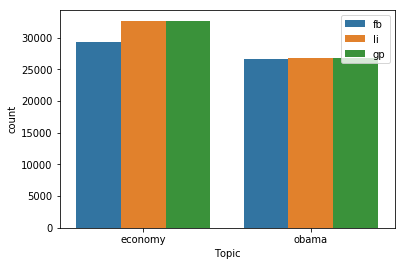

In [49]:
#count plot
sns.countplot('Topic',hue='sm',data=data)
plt.legend(loc=0)
plt.show()

Popularity based on weekday and weekend

In [50]:
final['weekday']=final['month'].apply(lambda x:x.weekday())

In [51]:
final['weekday/weekend']=np.where(final['weekday']<=5,'weekday','weekend')

In [52]:
final.tail()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month,weekday,weekday/weekend
93230,61860.0,American Airlines' 787-9 with premium economy ...,The Fort Worth-based airline's first Boeing 78...,Fort Worth Star Telegram (blog),economy,2016-07-07 15:11:10,0.075378,0.288825,-1.0,0.0,0.0,Online,2016-07-01,4,weekday
93231,61858.0,UK economy heading for marked slowdown after s...,"LONDON, (Reuters) – Britain's economy looks se...",euronews,economy,2016-07-07 15:16:05,0.000000,-0.196260,-1.0,0.0,0.0,Television,2016-07-01,4,weekday
93232,61863.0,UK economy heading for marked slowdown after Q...,"LONDON, July 7 (Reuters) - Britain's economy l...",Daily Mail,economy,2016-07-07 15:20:05,0.037689,-0.191747,-1.0,0.0,0.0,Dailies/Journals,2016-07-01,4,weekday
93234,61851.0,Stocks rise as investors key in on US economy ...,The June employment report is viewed as a cruc...,MarketWatch,economy,2016-07-07 15:31:05,0.104284,0.044943,-1.0,3.0,5.0,Dailies/Journals,2016-07-01,4,weekday
93235,61865.0,Russian PM proposes to use conservative and to...,"In addition, establish stimulating economic po...",TASS,economy,2016-07-07 15:31:10,0.072194,0.000000,-1.0,0.0,1.0,Dailies/Journals,2016-07-01,4,weekday


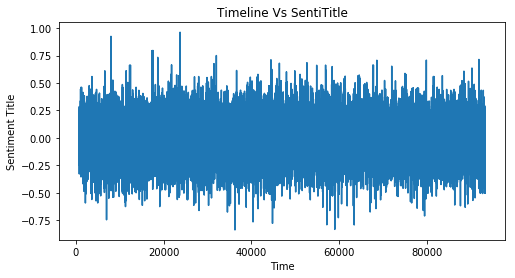

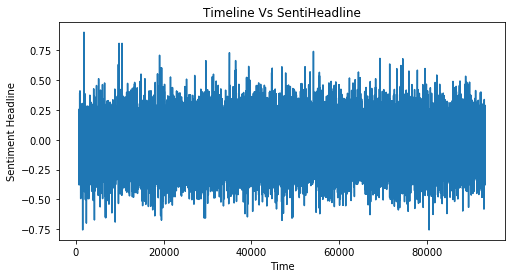

In [53]:
#Sentiment analysis of title and headlines 
sentiment_title = final.SentimentTitle
sentiment_headline = final.SentimentHeadline

plt.figure(figsize=(8, 4))
plt.plot(sentiment_title)
plt.xlabel('Time')
plt.ylabel('Sentiment Title')
plt.title('Timeline Vs SentiTitle')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(sentiment_headline)
plt.xlabel('Time')
plt.ylabel('Sentiment Headline')
plt.title('Timeline Vs SentiHeadline')
plt.show()

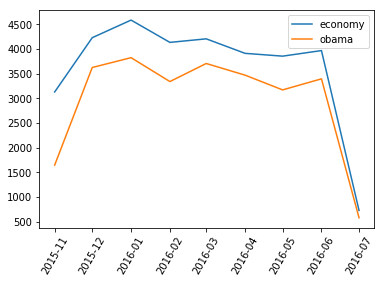

In [54]:
#Count of obama and economy per month
print('\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).IDLink.count(),label=i)
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [55]:
final[final['Topic']=='obama'].groupby(['month']).month.value_counts()

month       month     
2015-11-01  2015-11-01    1645
2015-12-01  2015-12-01    3624
2016-01-01  2016-01-01    3823
2016-02-01  2016-02-01    3339
2016-03-01  2016-03-01    3705
2016-04-01  2016-04-01    3469
2016-05-01  2016-05-01    3170
2016-06-01  2016-06-01    3394
2016-07-01  2016-07-01     578
Name: month, dtype: int64

In [56]:
final[final['Topic']=='economy'].groupby(['month']).month.value_counts()

month       month     
2015-11-01  2015-11-01    3128
2015-12-01  2015-12-01    4228
2016-01-01  2016-01-01    4585
2016-02-01  2016-02-01    4133
2016-03-01  2016-03-01    4205
2016-04-01  2016-04-01    3911
2016-05-01  2016-05-01    3854
2016-06-01  2016-06-01    3967
2016-07-01  2016-07-01     726
Name: month, dtype: int64

Sentiment Title



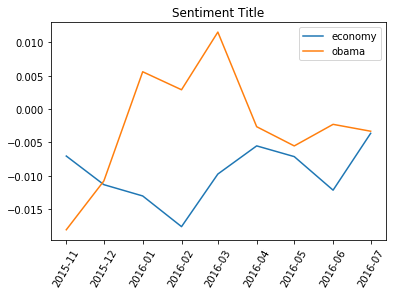

Sentiment HeadLine



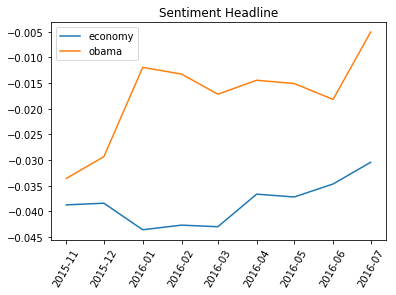

In [57]:
# avarage sentiments of economy and obama
print('Sentiment Title\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).SentimentTitle.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Sentiment Title')
plt.legend()
plt.show()

print('Sentiment HeadLine\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).SentimentHeadline.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Sentiment Headline')
plt.legend()
plt.show()

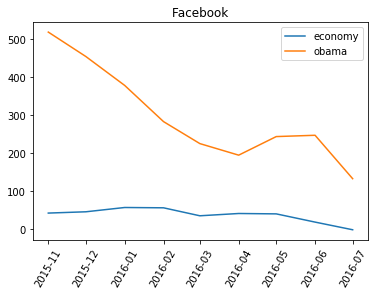

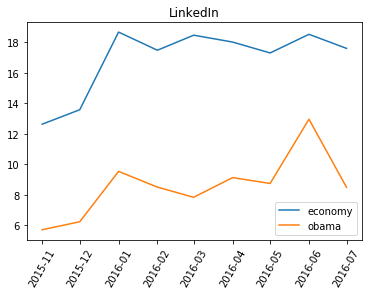

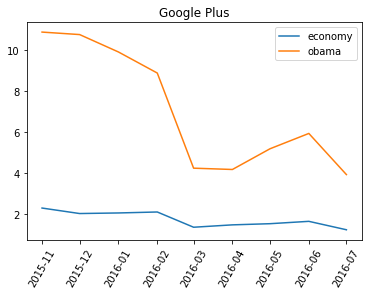

In [58]:
# Plot 1- Average unique topics in facebook for each month

for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).Facebook.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Facebook')
plt.legend()
plt.show()

# Plot 2- Average unique topics in LinkedIn for each month


for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).LinkedIn.mean(),label=i)
plt.xticks(rotation=60)
plt.title('LinkedIn')
plt.legend()
plt.show()

#Plot 3- Average unique topics in GooglePlus for each month

for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).GooglePlus.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Google Plus')
plt.legend()
plt.show()

In [59]:
facebook = [fb_obama,fb_economy]   #concating all the items according to the social platform
facebook = pd.concat(facebook)

linkedin = [li_obama,li_economy]
linkedin = pd.concat(linkedin)

gplus = [gp_obama,gp_economy]
googleplus = pd.concat(gplus)

Facebook:




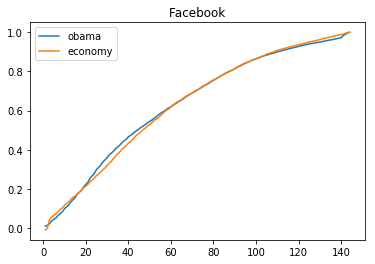

LinkedIN:




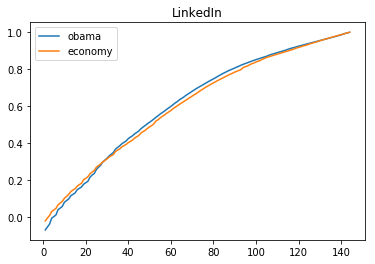

Google Plus:




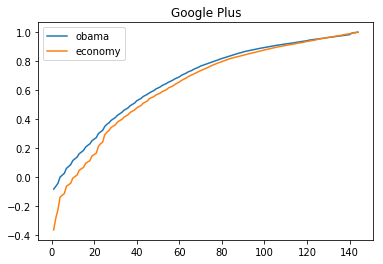

In [60]:
#plot-1 The grap explains the time span the news took to enter social media platform
print('Facebook:\n\n')

columns = [i for i in facebook if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(fb_obama[i])
    t_ec=np.mean(fb_economy[i])
    l1.append(t_ob/np.mean(fb_obama['TS144']))
    l2.append(t_ec/np.mean(fb_economy['TS144']))
plt.plot(l3,l1,label='obama')
plt.plot(l3,l2,label='economy')
plt.title('Facebook')
plt.legend()
plt.show()

print('LinkedIN:\n\n')

columns = [i for i in linkedin if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(li_obama[i])
    t_ec=np.mean(li_economy[i])
    l1.append(t_ob/np.mean(li_obama['TS144']))
    l2.append(t_ec/np.mean(li_economy['TS144']))
plt.plot(l3,l1,label='obama')
plt.plot(l3,l2,label='economy')
plt.title('LinkedIn')
plt.legend()
plt.show()

print('Google Plus:\n\n')

columns = [i for i in googleplus if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(gp_obama[i])
    t_ec=np.mean(gp_economy[i])
    l1.append(t_ob/np.mean(gp_obama['TS144']))
    l2.append(t_ec/np.mean(gp_economy['TS144']))
plt.plot(l3,l1,label='obama')
plt.plot(l3,l2,label='economy')
plt.title('Google Plus')
plt.legend()
plt.show()

ECONOMY :
FB :


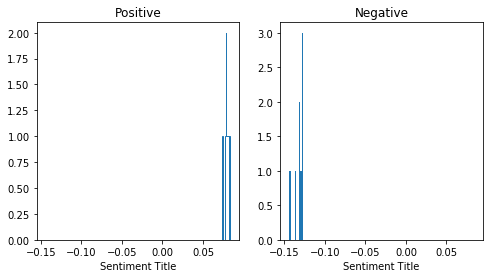

LI :


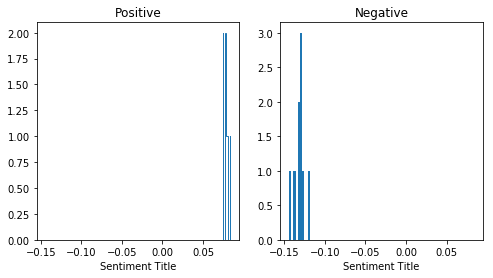

GP :


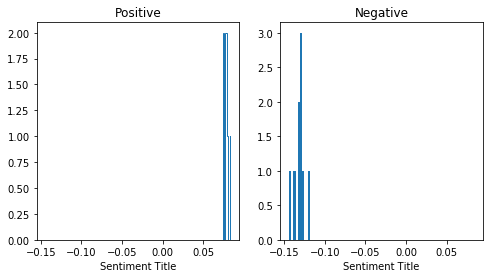

OBAMA :
FB :


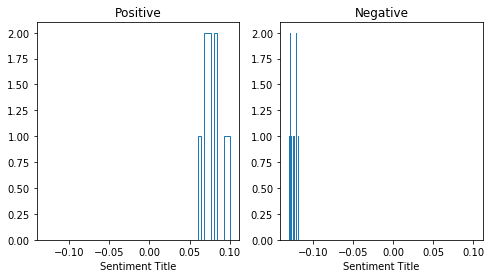

LI :


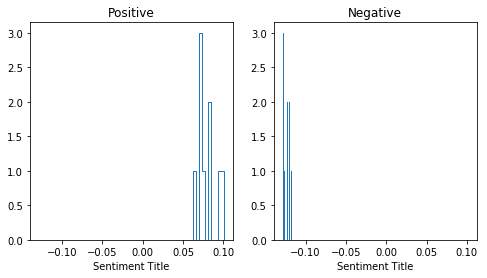

GP :


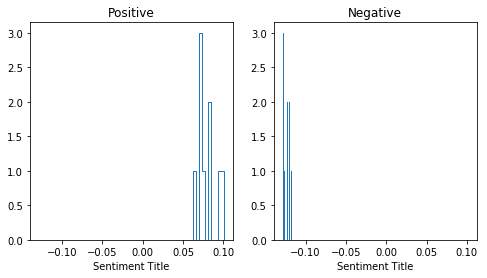

In [61]:
#The plots demonstrates the positive and negative score of Economy and Obama in 3 different social media platform

for i in data.Topic.unique():
    temp=data[data['Topic']==i]
    
    print(i.upper(),':')
    for j in temp.sm.unique():
        print(j.upper(),':')
        t = temp[temp['sm']==j]
        temp_pos=t[t['SentimentTitle']>=0]
        temp_neg=t[t['SentimentTitle']<0]
        
        f , ax_arr = plt.subplots(1 , 2 , figsize=(8,4),sharex=True)
        
        ax_arr[0].hist(temp_pos.groupby('month')['SentimentTitle'].mean(),align='mid',histtype='step')
        ax_arr[0].set_title('Positive')
        ax_arr[0].set_xlabel('Frequency')
        ax_arr[0].set_xlabel('Sentiment Title')
        
    
        ax_arr[1].hist(temp_neg.groupby('month')['SentimentTitle'].mean())
        ax_arr[1].set_title('Negative')
        ax_arr[1].set_xlabel('Frequency')
        ax_arr[1].set_xlabel('Sentiment Title')
        

        plt.show()

## Sentiment Score Calculation

In [62]:
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month,weekday,weekday/weekend
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,0.0,Online,2015-11-01,6,weekend


In [63]:
df = final

In [64]:
df['Positive'] = np.where(round(df['SentimentTitle'])<0,0,1)

In [65]:
sentiment = SentimentIntensityAnalyzer()
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    if compound<0:
        return 0
    else:
        return 1
    
df['vaderTitle']=df['Title'].apply(get_sentiment)

accuracy_score(df['Positive'],df['vaderTitle'])

0.713019045696211

In [66]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    if compound<0:
        return 0
    else:
        return 1
    
df['textblobTitle']=df['Title'].apply(get_sentiment)
accuracy_score(df['Positive'],df['textblobTitle'])

0.8736456019920587

In [67]:
df['Positive_HL'] = np.where(round(df['SentimentHeadline'])<0,0,1)

In [68]:
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    if compound<0:
        return 0
    else:
        return 1
    
df['vaderHL']=df['Headline'].apply(get_sentiment)

accuracy_score(df['Positive_HL'],df['vaderHL'])

0.6806480920654149

In [69]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    if compound<0:
        return 0
    else:
        return 1
    
df['textblobHL']=df['Headline'].apply(get_sentiment)

accuracy_score(df['Positive_HL'],df['textblobHL'])

0.8070866141732284

In [70]:
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    return compound
    
df['vaderHL']=df['Headline'].apply(get_sentiment)
df['vaderTitle']=df['Title'].apply(get_sentiment)

In [71]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    return compound
    
df['textblobTitle']=df['Title'].apply(get_sentiment)
df['textblobHL']=df['Headline'].apply(get_sentiment)

## Topic Modelling

In [72]:
df_obama = df[df['Topic'] == 'obama']
df_economy = df[df['Topic'] == 'economy']

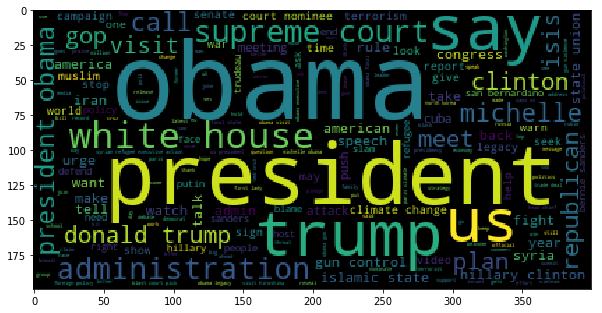

In [73]:
#Corpus

docs = df_obama.Title.str.lower().str.replace('[^a-z\' ]','')
stopwords = nltk.corpus.stopwords.words('English')
stopwords.extend(['obama','barack','say','call','new'])

stemmer = nltk.stem.PorterStemmer()
def clean_sen(text):
    text=str(text)
    ws = text.split(' ')
    ws = [w.strip() for w in ws]
    ws_clean = [w for w in ws if w not in stopwords]
    return ' '.join(ws_clean)

docs_clean = docs.apply(clean_sen)

#Merging all paragraphs as a single string
text = ' '.join(para for para in docs_clean)

#Creating the word cloud
plt.figure(figsize=(10,10))
wc = WordCloud().generate(text)
plt.imshow(wc)

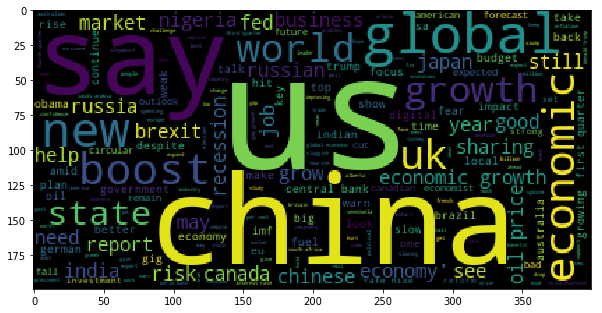

In [74]:
#Corpus

docs = df_economy.Title.str.lower().str.replace('[^a-z\' ]','')
stopwords = nltk.corpus.stopwords.words('English')
stopwords.extend(['economy'])

stemmer = nltk.stem.PorterStemmer()
def clean_sen(text):
    text=str(text)
    ws = text.split(' ')
    ws_clean = [w for w in ws if w not in stopwords]
    return ' '.join(ws_clean)

docs_clean = docs.apply(clean_sen)

#Merging all paragraphs as a single string
text = ' '.join(para for para in docs_clean)

#Creating the word cloud
plt.figure(figsize=(10,10))
wc = WordCloud().generate(text)
plt.imshow(wc)

In [75]:
docs_title = df['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = df['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

In [76]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend([])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [stemmer.stem(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [77]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend([])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [stemmer.stem(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [78]:
import gensim

dictionary_t = gensim.corpora.Dictionary(docs_title_clean)
dictionary_hl = gensim.corpora.Dictionary(docs_headline_clean)

In [79]:
docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_headline.append(bow)

In [80]:
c_scores = []
for i in range(4,20):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

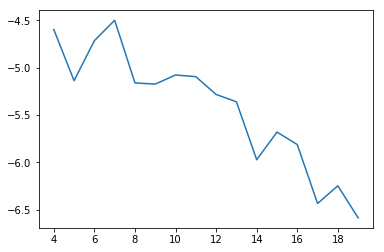

In [81]:
l1=list(range(4,20))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [82]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=5,random_state=100)

In [83]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.023085957),
 (1, 0.56549096),
 (2, 0.023052722),
 (3, 0.02253377),
 (4, 0.36583653)]

In [84]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]['Topic']

3    3
2    2
0    0
4    4
1    1
Name: Topic, dtype: int64

In [85]:
lda_model.print_topics()

[(0,
  '0.111*"economi" + 0.022*"obama" + 0.017*"" + 0.009*"econom" + 0.009*"say" + 0.008*"china" + 0.007*"us" + 0.007*"global" + 0.006*"court" + 0.006*"uk"'),
 (1,
  '0.070*"obama" + 0.051*"economi" + 0.046*"" + 0.013*"us" + 0.009*"plan" + 0.007*"trump" + 0.007*"deal" + 0.007*"say" + 0.007*"saudi" + 0.006*"trade"'),
 (2,
  '0.103*"" + 0.089*"obama" + 0.029*"economi" + 0.017*"presid" + 0.007*"visit" + 0.006*"call" + 0.006*"econom" + 0.005*"barack" + 0.005*"us" + 0.005*"state"'),
 (3,
  '0.098*"obama" + 0.048*"" + 0.040*"economi" + 0.011*"trump" + 0.009*"clinton" + 0.009*"presid" + 0.008*"us" + 0.006*"administr" + 0.006*"say" + 0.006*"new"'),
 (4,
  '0.084*"economi" + 0.054*"" + 0.028*"obama" + 0.017*"brexit" + 0.015*"us" + 0.015*"growth" + 0.014*"econom" + 0.013*"say" + 0.012*"china" + 0.011*"global"')]

In [86]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [87]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [88]:
temp = df[df['Topic']=='obama']

docs_title = temp['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = temp['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['obama','','barack','say','call','new','obamas','u'])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [89]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['obama','','barack','say','call','new','obamas','u'])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [90]:
dictionary_t = gensim.corpora.Dictionary(docs_title_clean)
dictionary_hl = gensim.corpora.Dictionary(docs_headline_clean)

docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_headline.append(bow)

In [91]:
c_scores = []
for i in range(1,10 ):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

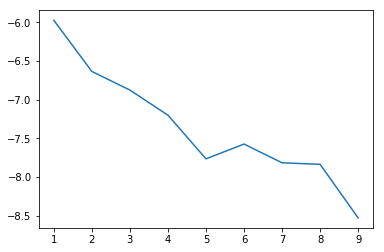

In [92]:
l1=list(range(1,10))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [93]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=2,random_state=100)

In [94]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.8065787), (1, 0.19342132)]

In [95]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]['Topic']

1    1
0    0
Name: Topic, dtype: int64

In [96]:
lda_model.print_topics()

[(0,
  '0.013*"president" + 0.010*"visit" + 0.009*"house" + 0.009*"white" + 0.007*"michelle" + 0.006*"clinton" + 0.006*"orlando" + 0.005*"administration" + 0.005*"trump" + 0.005*"meet"'),
 (1,
  '0.020*"president" + 0.018*"trump" + 0.008*"gun" + 0.007*"court" + 0.007*"clinton" + 0.006*"supreme" + 0.006*"plan" + 0.005*"gop" + 0.005*"orlando" + 0.005*"donald"')]

Topic modeling for Economy

In [97]:
temp_eco = df[df['Topic']=='economy']

docs_title = temp_eco['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = temp_eco['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['economy','us','say','would','could','new',''])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [98]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['economy','us','say','would','could','new',''])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [99]:
dictionary_e = gensim.corpora.Dictionary(docs_title_clean)
dictionary_eco = gensim.corpora.Dictionary(docs_headline_clean)

docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_e.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_e.doc2bow(doc)
    docs_bow_headline.append(bow)

In [100]:
c_scores = []
for i in range(1,10 ):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_e,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

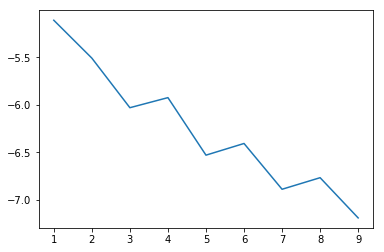

In [101]:
l1=list(range(1,10))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [102]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_e,num_topics=5,random_state=100)

In [103]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.029209437),
 (1, 0.02998293),
 (2, 0.02909006),
 (3, 0.028846396),
 (4, 0.8828712)]

In [104]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]

,Topic,Probablity
3,3,0.028846
2,2,0.029090
0,0,0.029209
1,1,0.029955
4,4,0.882899


In [105]:
lda_model.print_topics()

[(0,
  '0.015*"global" + 0.014*"year" + 0.014*"world" + 0.010*"economic" + 0.010*"china" + 0.008*"bank" + 0.007*"oil" + 0.006*"growth" + 0.006*"market" + 0.005*"plan"'),
 (1,
  '0.047*"brexit" + 0.021*"uk" + 0.021*"economic" + 0.019*"growth" + 0.010*"global" + 0.006*"china" + 0.006*"still" + 0.004*"risk" + 0.004*"hit" + 0.004*"sharing"'),
 (2,
  '0.021*"china" + 0.019*"economic" + 0.008*"market" + 0.007*"job" + 0.006*"stock" + 0.006*"japan" + 0.006*"growth" + 0.006*"oil" + 0.005*"global" + 0.005*"quarter"'),
 (3,
  '0.015*"global" + 0.012*"economic" + 0.010*"boost" + 0.009*"trump" + 0.008*"bank" + 0.007*"rate" + 0.007*"job" + 0.006*"growth" + 0.006*"india" + 0.006*"growing"'),
 (4,
  '0.012*"economic" + 0.011*"china" + 0.008*"grows" + 0.008*"grow" + 0.008*"percent" + 0.007*"minister" + 0.007*"vote" + 0.006*"impact" + 0.006*"sharing" + 0.006*"grew"')]

In [106]:
 df.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,...,S_Source,month,weekday,weekday/weekend,Positive,vaderTitle,textblobTitle,Positive_HL,vaderHL,textblobHL
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,...,Online,2015-11-01,6,weekend,1,0.1779,0.0,1,0.7269,0.131250
728,227.0,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0.0,0.0,...,Online,2015-11-01,6,weekend,1,0.1779,0.0,1,0.6249,0.084091


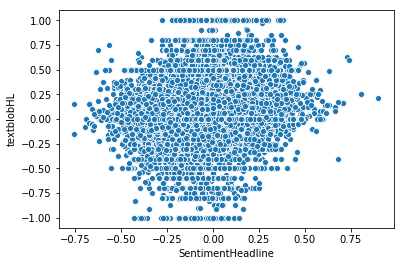

In [107]:
sns.scatterplot(df.SentimentHeadline,df.textblobHL)

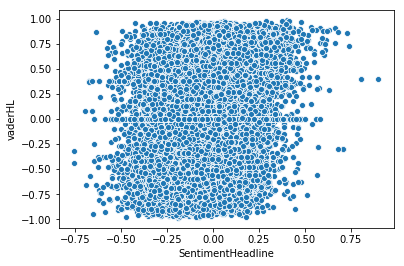

In [108]:
sns.scatterplot(df.SentimentHeadline,df.vaderHL)

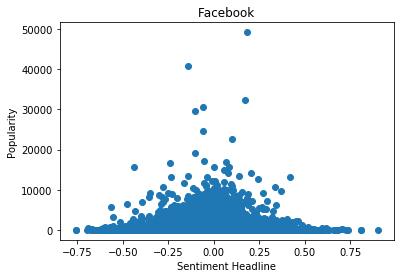

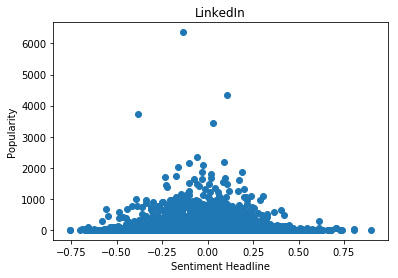

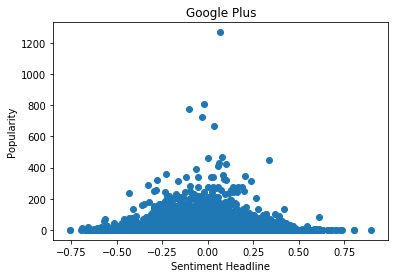

In [109]:
plt.scatter(df.SentimentHeadline,df.Facebook)
plt.title('Facebook')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()

plt.scatter(df.SentimentHeadline,df.LinkedIn)
plt.title('LinkedIn')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()

plt.scatter(df.SentimentHeadline,df.GooglePlus)
plt.title('Google Plus')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()